## Initialize Dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from PIL import Image
import requests
import os
import zipfile

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)

## Download and unpack Dataset from Kaggle

In [2]:
file_name = "neu-metal-surface-defects-data.zip"
if os.path.exists(file_name):
    print(f"{file_name} exists, skipping download.")
else:
    url = "https://www.kaggle.com/api/v1/datasets/download/fantacher/neu-metal-surface-defects-data"
    
    try:
        response = requests.get(url, allow_redirects=True)
        response.raise_for_status()
        
        with open(file_name, 'wb') as f:
            f.write(response.content)
            print(f"Dataset '{file_name}' downloaded successfully.")
        with zipfile.ZipFile("./neu-metal-surface-defects-data.zip", 'r') as zip_ref:
            zip_ref.extractall(".")
            print(f"Dataset '{file_name}' unpacked successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")

neu-metal-surface-defects-data.zip exists, skipping download.


## Select device

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Find W, H of Image

In [4]:
with Image.open("./NEU Metal Surface Defects Data/test/Crazing/Cr_1.bmp") as img:
    width, height = img.size

    print(f"Image Width: {width}")
    print(f"Image Height: {height}")

Image Width: 200
Image Height: 200


## Convert to Torchvision ImageFolder

In [5]:
TRAIN_DATA_PATH="./NEU Metal Surface Defects Data/train"
TEST_DATA_PATH="./NEU Metal Surface Defects Data/test"
TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM)

train_data_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=10, shuffle=False)

## Preview

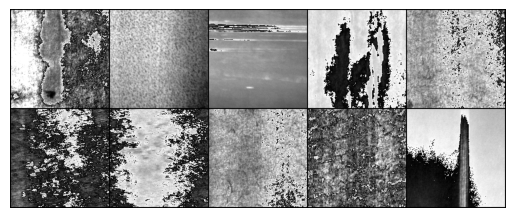

tensor([2, 3, 5, 1, 0, 4, 4, 0, 0, 5])


In [6]:
dataiter = iter(train_data_loader)
images, labels = next(dataiter)

grid = torchvision.utils.make_grid(images, nrow=5)
img = torchvision.transforms.ToPILImage()(grid)
plt.imshow(img)
plt.axis("off")
plt.show()
print(labels)

## Create the CNN

In [7]:
class MetalClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=2)
        self.fc1 = nn.Linear(in_features=16*49*49, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=6)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Train network

In [8]:
classifier = MetalClassifier().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

for epoch in range(20):
    classifier.train()

    running_loss=0.0
    for i, data in enumerate(train_data_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = classifier(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i%100 == 99:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 99:.3f}')
            running_loss = 0.0
print('Training done!')

[1,   100] loss: 1.430
[2,   100] loss: 0.738
[3,   100] loss: 0.402
[4,   100] loss: 0.375
[5,   100] loss: 0.253
[6,   100] loss: 0.203
[7,   100] loss: 0.171
[8,   100] loss: 0.121
[9,   100] loss: 0.166
[10,   100] loss: 0.108
[11,   100] loss: 0.185
[12,   100] loss: 0.076
[13,   100] loss: 0.127
[14,   100] loss: 0.159
[15,   100] loss: 0.115
[16,   100] loss: 0.109
[17,   100] loss: 0.039
[18,   100] loss: 0.052
[19,   100] loss: 0.059
[20,   100] loss: 0.052
Training done!


## Test

In [9]:
classifier.eval()
total_samples = 0
total_correct = 0
with torch.no_grad():
    for images, labels in test_data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = classifier(images)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        total_correct += (predicted==labels).sum().item()
accuracy = 100 * total_correct / total_samples
print(f'Test Acc: {accuracy:.2f}%')

Test Acc: 94.52%
